In [250]:
import pandas as pd

In [251]:
import numpy as np

In [252]:
import matplotlib as plt

In [253]:
import csv as csv

In [254]:
from sklearn.linear_model import LinearRegression

In [255]:
from sklearn.model_selection import train_test_split

In [256]:
import matplotlib.pyplot as plt

In [258]:
dst_labels = pd.read_csv("/home/rfere/Documents/Projects/spaceapps/datasets/dst_labels.csv")

In [260]:
solar_wind = pd.read_csv("/home/rfere/Documents/Projects/spaceapps/datasets/solar_wind.csv")

In [261]:
sun_spots = pd.read_csv("/home/rfere/Documents/Projects/spaceapps/datasets/sunspots.csv")

In [262]:
satellite_positions = pd.read_csv("/home/rfere/Documents/Projects/spaceapps/datasets/satellite_positions.csv")

In [263]:
mixed_table = pd.merge(dst_labels, solar_wind, on=["timedelta", "period"])

In [264]:
clean_mixed_table = mixed_table.dropna(subset=["bx_gse", "phi_gsm", "density", "speed", "temperature", "source"])

In [265]:
clean_mixed_table = pd.merge(clean_mixed_table, sun_spots, on=["timedelta", "period"], how="left")

In [266]:
min_sun_spots = sun_spots["smoothed_ssn"].mean() / 2
clean_mixed_table["smoothed_ssn"] = clean_mixed_table["smoothed_ssn"].replace(np.nan, min_sun_spots)

# En está tabla tomamos los datos iguales a cero y los remplazamos por la media, puesto que opinamos que estos datos pueden ser resultado de la mala sensibilidad del sensor debido al prolongado tiempo de vida dado al discovery.

In [267]:
clean_mixed_table["rounded_timedelta"] = clean_mixed_table["timedelta"].apply(lambda row_val: pd.to_timedelta(row_val).round("d"))

# En está tabla redondeamos los lapsos de horas a días, para que la columna en común (la fecha) fuera combinada con la tabla "maestra"

In [268]:
satellite_positions["rounded_timedelta"] = satellite_positions["timedelta"].apply(lambda row_val: pd.to_timedelta(row_val).round("d"))

In [269]:
satellite_positions = satellite_positions.drop(["timedelta"], axis=1)

# Se elimino la tabla de timedelta para evitar mezclas con la tabla maestra 

In [270]:
last_df = pd.merge(clean_mixed_table, satellite_positions, on=["period", "rounded_timedelta"], how="left")

In [271]:
last_df.dropna(inplace=True)

In [272]:
print(last_df.info())
# b = campo magnetico (vector de campo)

<class 'pandas.core.frame.DataFrame'>
Index: 24176 entries, 49180 to 73499
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype          
---  ------             --------------  -----          
 0   period             24176 non-null  object         
 1   timedelta          24176 non-null  object         
 2   dst                24176 non-null  int64          
 3   bx_gse             24176 non-null  float64        
 4   by_gse             24176 non-null  float64        
 5   bz_gse             24176 non-null  float64        
 6   theta_gse          24176 non-null  float64        
 7   phi_gse            24176 non-null  float64        
 8   bx_gsm             24176 non-null  float64        
 9   by_gsm             24176 non-null  float64        
 10  bz_gsm             24176 non-null  float64        
 11  theta_gsm          24176 non-null  float64        
 12  phi_gsm            24176 non-null  float64        
 13  bt                 24176 non-null  float64     

1. `proton_vx_gse`: Velocidad de los protones en la dirección X en el sistema de referencia GSE (Geocéntrico Solar Eclíptico).

2. `proton_vy_gse`: Velocidad de los protones en la dirección Y en el sistema de referencia GSE.

3. `proton_vz_gse`: Velocidad de los protones en la dirección Z en el sistema de referencia GSE.

4. `proton_vx_gsm`: Velocidad de los protones en la dirección X en el sistema de referencia GSM (Geocéntrico Solar Magnetosférico).

5. `proton_vy_gsm`: Velocidad de los protones en la dirección Y en el sistema de referencia GSM.

6. `proton_vz_gsm`: Velocidad de los protones en la dirección Z en el sistema de referencia GSM.

7. `proton_speed`: Velocidad total de los protones.

8. `proton_density`: Densidad de protones en el entorno espacial.

9. `proton_temperature`: Temperatura de los protones en el entorno espacial.

10. `bt`: Componente total del campo magnético en el espacio.

11. `bx_gse`: Componente X del campo magnético en el sistema de referencia GSE.

12. `by_gse`: Componente Y del campo magnético en el sistema de referencia GSE.

13. `bz_gse`: Componente Z del campo magnético en el sistema de referencia GSE.

In [273]:
x = last_df[['bx_gse', 'by_gse', 'bz_gse', 'bx_gsm', 'by_gsm', 'bz_gsm', 'bt', 'density', 'speed', 'temperature', 'smoothed_ssn', 'gse_x_dscovr', 'gse_y_dscovr', 'gse_z_dscovr']]
y = last_df[['dst']]

In [274]:
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.8, test_size = 0.2, random_state = 6)

In [275]:
mlr = LinearRegression()

In [276]:
mlr.fit(x_train, y_train)

LinearRegression()

In [277]:
y_predict = mlr.predict(x_test)

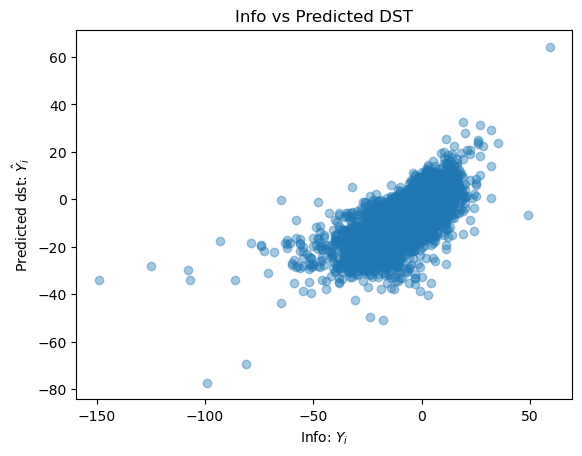

In [278]:
plt.scatter(y_test, y_predict, alpha=0.4)
plt.xlabel("Info: $Y_i$")
plt.ylabel("Predicted dst: $\hat{Y}_i$")
plt.title("Info vs Predicted DST")

plt.show()

# Auqí podemos observar más a detalle la correlación de nuestro modelo con respecto a los resultados reales. Debido a los fallos de la Discovery por su extendido periodo de vida, es dificil obtener una relación linear fuerte, sin embargo creemos que los de los resultados, incluso con lo mencionado anteriormente es un resultado positivo.

In [279]:
print(mlr.coef_)

[[ 3.45230434e+02 -4.46184818e-01 -1.57468847e+00 -3.45119354e+02
   4.66187437e-01  2.36299996e+00 -1.23085571e+00  7.40085215e-01
  -6.11346317e-02 -2.41123048e-06 -8.95742786e-02  1.45797989e-05
   5.64518834e-06 -3.20637719e-06]]


In [280]:
print("Train score:")
print(mlr.score(x_train, y_train))

print("Test score:")
print(mlr.score(x_test, y_test))

Train score:
0.48135302025027304
Test score:
0.46991509600476733


# CORRELACION (-1 al 1) de 0.47.